# Uncertainty Analysis Example

This notebook demonstrates how to calculate and visualize measurement uncertainty for voltage readings following the GUM (Guide to the Expression of Uncertainty in Measurement) methodology.

In [23]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt

# Import utility functions for uncertainty calculations
from workbench.utils import get_type_a_uncertainty, get_type_b_uncertainty, get_expanded_uncertainty, format_timedelta
from workbench.utils import get_type_b_uncertainties, get_expanded_uncertainties

# Load test data from CSV file
# The dataset contains voltage measurements taken over time with corresponding system temperature
test_data = np.genfromtxt("test-data.csv", delimiter=",", skip_header=1, dtype=[
    ('timestamp', 'datetime64[ms]'),  # Timestamp of each measurement
    ('voltage', 'float64'),           # Voltage readings in volts
    ('system_temperature', 'float64'),# System temperature in degrees Celsius
])

## Data Summary

First, we analyze the basic statistical properties of our measurement dataset to understand its characteristics and quality.

In [24]:
from workbench.utils import format_voltage

# Create a summary table with key statistics about the measurements
# This helps assess the stability and overall behavior of the measured voltage
pd.DataFrame([
    ["Sample size", len(test_data)],                                                      # Number of measurements
    ["Start", test_data["timestamp"].min()],                                              # First measurement time
    ["End", test_data["timestamp"].max()],                                                # Last measurement time
    ["Duration", format_timedelta(test_data["timestamp"][-1] - test_data["timestamp"][0])], # Total measurement duration
    ["Min", format_voltage(test_data["voltage"].min(), precision=7)],                     # Minimum voltage value
    ["Max", format_voltage(test_data["voltage"].max(), precision=7)],                     # Maximum voltage value
    ["Mean", format_voltage(test_data["voltage"].mean(), precision=7)],                   # Mean voltage value
    ["Sample standard deviation", format_voltage(test_data["voltage"].std(ddof=1))],      # Standard deviation (n-1)
], columns=["", "Measurements"])

,,Measurements
0,Sample size,5259
1,Start,2024-12-24T00:00:01.686
2,End,2024-12-24T05:59:59.253
3,Duration,"0 days, 5 hours, 59 minutes"
4,Min,4.9981939 V
5,Max,4.9981985 V
6,Mean,4.9981962 V
7,Sample standard deviation,642.2 nV


## Uncertainty Calculation

Following the GUM methodology, we calculate both Type A and Type B uncertainties, then combine them to determine the expanded uncertainty.

In [25]:
# Type A uncertainty - derived from statistical analysis of the measurement series
# Calculated as the standard error of the mean (s/√n)
type_a_uncertainty = get_type_a_uncertainty(test_data["voltage"])

# Type B uncertainty - derived from instrument specifications
# For Keysight 34461A DMM, the 2-year DC voltage accuracy specification for 10V range is:
# ±(50 ppm of reading + 5 ppm of range)
# We convert this to expanded uncertainty values for each measurement
expanded_type_b_uncertainties = abs(test_data["voltage"]) * 50e-6 + 10 * 5e-6  # 10V range

# Convert expanded Type B uncertainties to standard uncertainty (divide by coverage factor k)
# Then calculate the root sum square to get a single Type B uncertainty value
type_b_uncertainty = get_type_b_uncertainty(expanded_type_b_uncertainties, k=2)

# Calculate expanded uncertainty by combining Type A and Type B uncertainties
# using the root sum square method, then multiplying by coverage factor k=2 (95% confidence)
expanded_uncertainty = get_expanded_uncertainty(type_a_uncertainty, type_b_uncertainty, k=2)

# Display the uncertainty budget
pd.DataFrame([
    ["Mean", format_voltage(test_data["voltage"].mean(), precision=7)],
    ["Type A uncertainty (standard error of mean)", format_voltage(type_a_uncertainty)],
    ["Type B uncertainty (Keysight 34461A, 10 V, 2-year spec)", format_voltage(type_b_uncertainty)],
    ["Expanded uncertainty (k=2)", format_voltage(expanded_uncertainty)],
], columns=["", "Voltage"])

,,Voltage
0,Mean,4.9981962 V
1,Type A uncertainty (standard error of mean),8.9 nV
2,"Type B uncertainty (Keysight 34461A, 10 V, 2-y...",150.0 µV
3,Expanded uncertainty (k=2),299.9 µV


## Visualization of Measurements with Uncertainty

This section plots the voltage measurements over time with their associated uncertainty bands to provide a visual representation of the measurement quality

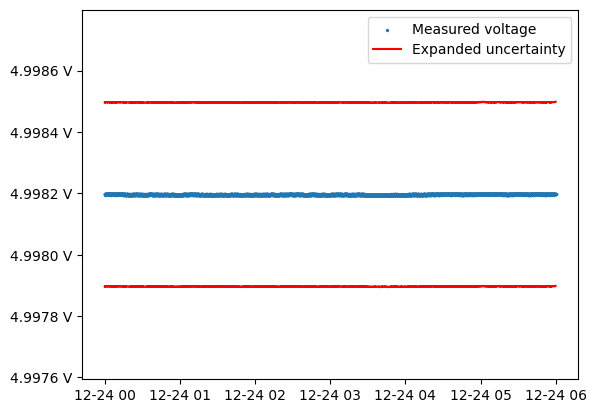

In [26]:
from matplotlib.ticker import FuncFormatter

fig, ax1 = plt.subplots()

# Recalculate uncertainties for visualization
# For each measurement point, we need its specific uncertainty
type_a_uncertainty = get_type_a_uncertainty(test_data["voltage"])
expanded_type_b_uncertainties = abs(test_data["voltage"]) * 50e-6 + 10 * 5e-6
type_b_uncertainties = get_type_b_uncertainties(expanded_type_b_uncertainties, k=2)

# Calculate expanded uncertainties for each measurement point
# Note: Unlike the single value calculated earlier, here we need an uncertainty value for each data point
expanded_uncertainties = get_expanded_uncertainties(type_a_uncertainty, type_b_uncertainties, k=2)

# Format y-axis to display voltage values with proper units
ax1.yaxis.set_major_formatter(
    FuncFormatter(lambda x, pos: format_voltage(x, precision=4)))

# Plot the voltage measurements as scatter points
ax1.scatter(test_data["timestamp"], test_data["voltage"], s=2, label="Measured voltage")

# Plot the uncertainty bands (measurement ± expanded uncertainty)
# These red lines represent the 95% confidence interval (k=2) for the true value
ax1.plot(test_data["timestamp"], test_data["voltage"] - expanded_uncertainties, color="red", label=f"Expanded uncertainty")
ax1.plot(test_data["timestamp"], test_data["voltage"] + expanded_uncertainties, color="red")

# Calculate the min and max values for y-axis with added padding
voltage_min = test_data["voltage"].min() - expanded_uncertainties.max() * 2
voltage_max = test_data["voltage"].max() + expanded_uncertainties.max() * 2

# Set y-axis limits to provide more space around minima and maxima
ax1.set_ylim(voltage_min, voltage_max)

# Add a legend to identify the uncertainty bands and position it in the upper right corner
ax1.legend(loc='upper right')

plt.show()